# Estimation of Autocorrelation Function (Block Tensor)

## (2d EA Square)

\begin{align}
H = -\sum_{<ij>}J_{ij}s_{i}s_{j} - \sum_{i}h_{i}s_{i},
\end{align}
where 
\begin{align}
    &J_{ij}\sim Bern([-1, 1], 1/2),\\
    &s_{i} \in \{-1, 1\}.
\end{align}
Here we set $h_{i} =0$. In the quench limit, we set
\begin{align}
    &J_{ij} = 1 \textit{ if $i$ is odd,}\\
    &J_{ij} = -1 \textit{ if $i$ is even,}
\end{align}

   * - * - * - *
 -1|   | -1|   |
   * - * - * - *
 -1|   | -1|   |
   * - * - * - *
 -1|   | -1|   |
   * - * - * - *

\begin{align}
q_{ea} = \sum_{i}s_{i}^{\alpha}s_{i}^{\beta},&\\
<q_{ea}> = \sum_{i}m_{i}^{\alpha}m_{i}^{\beta} = \sum_{i}m_{i}^{2}&
\end{align}
two copies $\alpha$ and $\beta$ are independent;

In [115]:
import numpy as np
import numba as nb

In [111]:
import csv
import pickle
import time
from tqdm.auto import trange

In [5]:
import seaborn as sns

In [6]:
import matplotlib.pyplot as plt

In [7]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.float64[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_float(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [8]:
types_corr_k_steps_est = nb.types.Tuple((nb.float64, nb.float64, nb.float64[:]))(nb.int32[:], nb.int64)
@nb.cfunc(types_corr_k_steps_est, parallel=True)
def corr_k_step_est_int(sample_array, k_steps_max):
    """
    Args:
        mc_list: (np.array)
        k_steps: (int)
    Return:
        corr_coef: (float)
    """
    sample_len = len(sample_array)
    num_i_steps = sample_len - k_steps_max
    q_mean = np.mean(sample_array[:num_i_steps])
    q_square_mean = np.mean(np.square(sample_array[:num_i_steps]))
    qqk_sum = np.zeros(k_steps_max)
    for i in range(num_i_steps):
        samples_k_sub = sample_array[i:i+k_steps_max+1]
        for j in range(1, k_steps_max+1):
            qqk_sum[j-1] += (samples_k_sub[0] * samples_k_sub[j])
    qqk_array = qqk_sum / num_i_steps
    return (q_mean, q_square_mean, qqk_array)

In [9]:
@nb.njit(parallel=True)
def autocorr_mc_mean_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros(m_times), np.zeros(m_times), np.zeros((m_times, k_steps_max))
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array
    for i in range(k_steps_max):
        qqk_mean_mc_i = np.mean(qqk_double_array[:, i])
        qqk_mean_std_mc_i = np.std(qqk_double_array[:, i])
        qqk_mean_mc[i] = qqk_mean_mc_i
        qqk_mean_std_mc[i] = qqk_mean_std_mc_i / np.sqrt(m_times)
    ####################################################
    q_mean_mc = np.mean(q_mean_array)
    q_mean_std_mc = np.std(q_mean_array) / np.sqrt(m_times)
    q_square_mean_mc = np.mean(q_square_mean_array)
    q_square_mean_std_mc = np.std(q_square_mean_array) / np.sqrt(m_times)
    ####################################################
    q_mean = (q_mean_mc, q_mean_std_mc)
    q_square_mean = (q_square_mean_mc, q_square_mean_std_mc)
    qqk_mean = (qqk_mean_mc, qqk_mean_std_mc)
    ####################################################
    autocorr_mc = (qqk_mean_mc - q_mean_mc ** 2) / (q_square_mean_mc - q_mean_mc ** 2) 
    return autocorr_mc, q_mean, q_square_mean, qqk_mean

In [10]:
@nb.njit(parallel=True)
def autocorr_mc_std_est(mc_array, k_steps_max):
    m_times = mc_array.shape[0]
    qqk_mean_mc, qqk_mean_std_mc = np.zeros(k_steps_max), np.zeros(k_steps_max)
    q_mean_array, q_square_mean_array, qqk_double_array = np.zeros((m_times, 1)), np.zeros((m_times, 1)), np.zeros((m_times, k_steps_max))
    autocorr_mc_mean, autocorr_mc_std = np.zeros(k_steps_max), np.zeros(k_steps_max)
    for i in range(m_times):
        q_mean, q_square_mean, qqk_array = corr_k_step_est_float(mc_array[i], k_steps_max)
        q_mean_array[i] = q_mean
        q_square_mean_array[i] = q_square_mean
        qqk_double_array[i] = qqk_array        
    ####################################################
    autocorr_mc_array = (qqk_double_array - q_mean_array ** 2) / (q_square_mean_array - q_mean_array ** 2)
    q_mean_mc = np.mean(q_mean_array)
    q_square_mean_mc = np.mean(q_square_mean_array)
    qqk_mc = np.mean(qqk_double_array)
    for j in range(k_steps_max):
        autocorr_mc_mean[j] = np.mean(autocorr_mc_array[:, j])
        autocorr_mc_std[j] = np.std(autocorr_mc_array[:, j]) / np.sqrt(m_times)
    return autocorr_mc_mean, autocorr_mc_std

In [11]:
def autocorr_time_est(autocorr_fun_list, t_trunc):
    num_steps = len(autocorr_fun_list)
    coeff_auto = np.polyfit(np.arange(num_steps), np.log(autocorr_fun_list), 1)
    k, b = coeff_auto
    auto_time_up = 1 / k * np.exp(k * t_trunc + b)
    auto_time_down = 1 / k
    autocorr_time = auto_time_up - auto_time_down  
    return autocorr_time

In [12]:
def autocorr_mean_std_est(file, shape, steps):
    with open(file, 'rb') as file:
        ea2d_dict = pickle.load(file)
        q_ea2d = ea2d_dict['q_history']
    q_ea2d = q_ea2d.reshape(shape)
    q_mean = np.mean(q_ea2d)
    autocorr_q_ea2d_mean, _, _, _ = autocorr_mc_mean_est(q_ea2d, steps)
    _, autocorr_q_ea2d_std = autocorr_mc_std_est(q_ea2d, steps)
    return q_mean, autocorr_q_ea2d_mean, autocorr_q_ea2d_std

In [13]:
def autocorr_est(file_list, shape, steps):
    q_mean_list, autocorr_mean_list, autocorr_std_list = [], [], []
    for file in file_list:
        q_mean, autocorr_mean_i, autocorr_std_i = autocorr_mean_std_est(file, shape, steps)
        q_mean_list.append(q_mean)
        autocorr_mean_list.append(autocorr_mean_i)
        autocorr_std_list.append(autocorr_std_i)
    return q_mean_list, autocorr_mean_list, autocorr_std_list

-----------
### Size = 4

In [14]:
with open('./data_2d_ea/ea_square_size_4/ea_square_size_4_beta_5.000_h_0.000_50E4_frust_tensor_torch_v4.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_4_v4 = data_dict['q_list']

In [15]:
with open('./data_2d_ea/ea_square_size_4/ea_square_size_4_beta_5.000_h_0.000_50E4_frust_tensor_torch_v5.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_4_v5 = data_dict['q_list']

<AxesSubplot:ylabel='Count'>

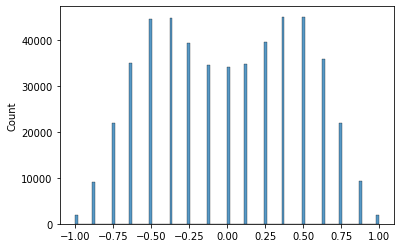

In [16]:
sns.histplot(q_ea2d_4_v5)

In [17]:
with open('./data_2d_ea/ea_square_size_4/ea_square_size_4_beta_5.000_h_0.000_50E4_frust_tensor_torch_v7.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_4_v7 = data_dict['q_list']

In [18]:
with open('./data_2d_ea/ea_square_size_4/ea_square_size_4_beta_5.000_h_0.000_50E4_frust_tensor_torch_v8.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_4_v8 = data_dict['q_list']

In [19]:
q_ea2d_4_v4 = np.reshape(q_ea2d_4_v4, (500, 1000))
q_ea2d_4_v5 = np.reshape(q_ea2d_4_v8, (500, 1000))
q_ea2d_4_v7 = np.reshape(q_ea2d_4_v7, (500, 1000))
q_ea2d_4_v8 = np.reshape(q_ea2d_4_v8, (500, 1000))

In [20]:
q_ea2d_4 = np.concatenate((q_ea2d_4_v4, q_ea2d_4_v5, 
                           q_ea2d_4_v7, q_ea2d_4_v8), axis=0)

In [21]:
q_ea2d_4.shape

(2000, 1000)

In [22]:
time_start = time.time()
autocorr_q_ea2d_4_mean, _, _, _ = autocorr_mc_mean_est(q_ea2d_4, 100)
_, autocorr_q_ea2d_4_std = autocorr_mc_std_est(q_ea2d_4, 100)
time_end = time.time()
print(time_end-time_start)

17.14626455307007


In [23]:
autocorr_q_ea2d_4_mean = np.insert(autocorr_q_ea2d_4_mean, 0, 1)
autocorr_q_ea2d_4_std = np.insert(autocorr_q_ea2d_4_std, 0, 0)

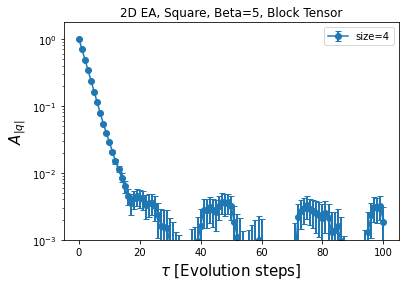

In [24]:
plt.errorbar(x=range(101), y=autocorr_q_ea2d_4_mean, yerr=autocorr_q_ea2d_4_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [Evolution steps]', fontsize=15)
plt.ylabel(r'$A_{|q|}$', fontsize=15)
plt.title("2D EA, Square, Beta=5, Block Tensor")
plt.legend()

In [25]:
q_abs_mean_4 = np.mean(np.abs(q_ea2d_4))

In [26]:
q_ea2d_4_mean = np.mean(autocorr_q_ea2d_4_mean)

In [27]:
print(f"q order of size 4 is: {q_ea2d_4_mean:.3f}.")

q order of size 4 is: 0.034.


In [28]:
autocorr_time_size_4 = np.sum(autocorr_q_ea2d_4_mean) - 1/2

In [29]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 2.903.


In [30]:
autocorr_time_size_4 = autocorr_time_est(autocorr_q_ea2d_4_mean[:10], 1000)

In [31]:
print(f"autocorr time of size 4 is: {autocorr_time_size_4:.3f}.")

autocorr time of size 4 is: 2.759.


-----------------------------
### Size = 8

In [32]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v0.pkl', 'rb') as file:
    q_ea2d_8_v0 = pickle.load(file)

In [33]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v1.pkl', 'rb') as file:
    q_ea2d_8_v1 = pickle.load(file)

In [34]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v2.pkl', 'rb') as file:
    q_ea2d_8_v2 = pickle.load(file)

In [35]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v3.pkl', 'rb') as file:
    q_ea2d_8_v3 = pickle.load(file)

In [36]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v4.pkl', 'rb') as file:
    q_ea2d_8_v4 = pickle.load(file)

In [37]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v5.pkl', 'rb') as file:
    q_ea2d_8_v5 = pickle.load(file)

In [38]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v6.pkl', 'rb') as file:
    q_ea2d_8_v6 = pickle.load(file)

In [39]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_23E4_frust_tensor_torch_v7.pkl', 'rb') as file:
    q_ea2d_8_v7 = pickle.load(file)

In [40]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_10E4_frust_tensor_torch_v10.pkl', 'rb') as file:
    q_ea2d_8_v10 = pickle.load(file)

In [41]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_10E4_frust_tensor_torch_v11.pkl', 'rb') as file:
    q_ea2d_8_v11 = pickle.load(file)

In [42]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_10E4_frust_tensor_torch_v13.pkl', 'rb') as file:
    q_ea2d_8_v13 = pickle.load(file)

In [43]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_10E4_frust_tensor_torch_v14.pkl', 'rb') as file:
    q_ea2d_8_v14 = pickle.load(file)

In [44]:
with open('./data_2d_ea/ea_square_size_8/ea_square_size_8_beta_5.000_h_0.000_10E4_frust_tensor_torch_v15.pkl', 'rb') as file:
    q_ea2d_8_v15 = pickle.load(file)

In [45]:
q_ea2d_8_v0 = np.reshape(q_ea2d_8_v0, (230, 1000))
q_ea2d_8_v1 = np.reshape(q_ea2d_8_v1, (230, 1000))
q_ea2d_8_v2 = np.reshape(q_ea2d_8_v2, (230, 1000))
q_ea2d_8_v3 = np.reshape(q_ea2d_8_v3, (230, 1000))
q_ea2d_8_v4 = np.reshape(q_ea2d_8_v4, (230, 1000))
q_ea2d_8_v5 = np.reshape(q_ea2d_8_v5, (230, 1000))
q_ea2d_8_v6 = np.reshape(q_ea2d_8_v6, (230, 1000))
q_ea2d_8_v7 = np.reshape(q_ea2d_8_v7, (230, 1000))
q_ea2d_8_v10 = np.reshape(q_ea2d_8_v10, (100, 1000))
q_ea2d_8_v11 = np.reshape(q_ea2d_8_v11, (100, 1000))
q_ea2d_8_v13 = np.reshape(q_ea2d_8_v13, (100, 1000))
q_ea2d_8_v14 = np.reshape(q_ea2d_8_v14, (100, 1000))
q_ea2d_8_v15 = np.reshape(q_ea2d_8_v15, (100, 1000))

In [46]:
q_ea2d_8 = np.concatenate((#q_ea2d_8_v0, 
                           q_ea2d_8_v1,
                           q_ea2d_8_v2,
                           q_ea2d_8_v3,
                           q_ea2d_8_v4,
                           q_ea2d_8_v5,
                           q_ea2d_8_v6,
                           q_ea2d_8_v7, 
                           q_ea2d_8_v10,
                           q_ea2d_8_v11, 
                           q_ea2d_8_v13, 
                           q_ea2d_8_v14, 
                           q_ea2d_8_v15), axis=0)

In [47]:
time_start = time.time()
autocorr_q_ea2d_8_mean, _, _, _ = autocorr_mc_mean_est(q_ea2d_8, 100)
_, autocorr_q_ea2d_8_std = autocorr_mc_std_est(q_ea2d_8, 100)
time_end = time.time()
print(time_end-time_start)

3.256087064743042


In [271]:
15 / 100 / 3600 * 10000 * 10

4.166666666666666

In [272]:
110.2 / 100 / 3600 * 10000

3.0611111111111113

In [48]:
autocorr_q_ea2d_8_mean = np.insert(autocorr_q_ea2d_8_mean, 0, 1)

In [49]:
autocorr_q_ea2d_8_std = np.insert(autocorr_q_ea2d_8_std, 0, 0)

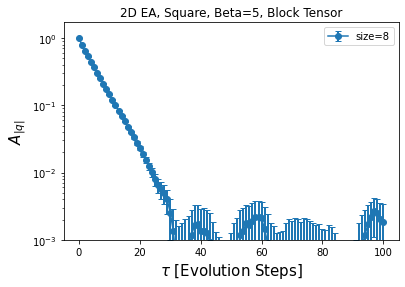

In [50]:
plt.errorbar(x=range(101), y=autocorr_q_ea2d_8_mean, yerr=autocorr_q_ea2d_8_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [Evolution Steps]', fontsize=15)
plt.ylabel(r'$A_{|q|}$', fontsize=15)
plt.title("2D EA, Square, Beta=5, Block Tensor")
plt.legend()

In [51]:
q_abs_mean_8 = np.mean(np.abs(q_ea2d_8))

In [52]:
autocorr_time_size_8 = np.sum(autocorr_q_ea2d_8_mean) - 1/2

In [53]:
print(f"autocorr time of size 4 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 4 is: 5.081.


In [54]:
autocorr_time_size_8 = autocorr_time_est(autocorr_q_ea2d_8_mean[:5], 1000)

In [55]:
print(f"autocorr time of size 4 is: {autocorr_time_size_8:.3f}.")

autocorr time of size 4 is: 4.960.


-----------
### Size = 16

In [57]:
with open('./data_2d_ea/ea_square_size_16_v4/ea_square_size_16_beta_5.000_h_0.000_15E4_frust_tensor_torch_v0.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_16_15E4_v0 = data_dict['q_list']

In [58]:
with open('./data_2d_ea/ea_square_size_16_v4/ea_square_size_16_beta_5.000_h_0.000_15E4_frust_tensor_torch_v1.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_16_15E4_v1 = data_dict['q_list']

In [59]:
with open('./data_2d_ea/ea_square_size_16_v4/ea_square_size_16_beta_5.000_h_0.000_15E4_frust_tensor_torch_v2.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_16_15E4_v2 = data_dict['q_list']

In [60]:
with open('./data_2d_ea/ea_square_size_16_v4/ea_square_size_16_beta_5.000_h_0.000_15E4_frust_tensor_torch_v3.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_16_15E4_v3 = data_dict['q_list']

In [61]:
with open('./data_2d_ea/ea_square_size_16_v4/ea_square_size_16_beta_5.000_h_0.000_15E4_frust_tensor_torch_v4.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_16_15E4_v4 = data_dict['q_list']

In [62]:
q_ea2d_16_15E4_v0 = np.reshape(q_ea2d_16_15E4_v0, (150, 1000))
q_ea2d_16_15E4_v1 = np.reshape(q_ea2d_16_15E4_v1, (150, 1000))
q_ea2d_16_15E4_v2 = np.reshape(q_ea2d_16_15E4_v2, (150, 1000))
q_ea2d_16_15E4_v3 = np.reshape(q_ea2d_16_15E4_v3, (150, 1000))
q_ea2d_16_15E4_v4 = np.reshape(q_ea2d_16_15E4_v4, (150, 1000))

In [63]:
q_ea2d_16_v20 = np.concatenate((q_ea2d_16_15E4_v0,
                                q_ea2d_16_15E4_v1,
                                q_ea2d_16_15E4_v2, 
                                q_ea2d_16_15E4_v3), axis=0)

In [64]:
with open('./data_2d_ea/ea_square_size_16_v3/ea_square_size_16_beta_5.000_h_0.000_8E4_frust_tensor_torch_v1.pkl', 'rb') as file:
    q_ea2d_16_8E4_v1 = pickle.load(file)

In [65]:
with open('./data_2d_ea/ea_square_size_16_v3/ea_square_size_16_beta_5.000_h_0.000_8E4_frust_tensor_torch_v2.pkl', 'rb') as file:
    q_ea2d_16_8E4_v2 = pickle.load(file)

In [66]:
q_ea2d_16_8E4_v1 = np.reshape(q_ea2d_16_8E4_v1, (20, 1000))
q_ea2d_16_8E4_v2 = np.reshape(q_ea2d_16_8E4_v2, (20, 1000))

In [67]:
q_ea2d_16_v19 = np.concatenate((q_ea2d_16_8E4_v1, q_ea2d_16_8E4_v2), axis=0)

In [68]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_15E3_frust_tensor_torch_v8.pkl', 'rb') as file:
    q_ea2d_16_15e3_v0 = pickle.load(file)

In [69]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_15E3_frust_tensor_torch_v10.pkl', 'rb') as file:
    q_ea2d_16_15e3_v1 = pickle.load(file)

In [70]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_15E3_frust_tensor_torch_v12.pkl', 'rb') as file:
    q_ea2d_16_15e3_v2 = pickle.load(file)

In [71]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_15E3_frust_tensor_torch_v13.pkl', 'rb') as file:
    q_ea2d_16_15e3_v3 = pickle.load(file)

In [72]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_15E3_frust_tensor_torch_v14.pkl', 'rb') as file:
    q_ea2d_16_15e3_v4 = pickle.load(file)

In [73]:
q_ea2d_16_15e3_v0 = np.reshape(q_ea2d_16_15e3_v0, (15, 1000))
q_ea2d_16_15e3_v1 = np.reshape(q_ea2d_16_15e3_v1, (15, 1000))
q_ea2d_16_15e3_v2 = np.reshape(q_ea2d_16_15e3_v2, (15, 1000))
q_ea2d_16_15e3_v3 = np.reshape(q_ea2d_16_15e3_v3, (15, 1000))
q_ea2d_16_15e3_v4 = np.reshape(q_ea2d_16_15e3_v4, (15, 1000))

In [74]:
q_ea2d_16_v18 = np.concatenate((q_ea2d_16_15e3_v0, 
                                q_ea2d_16_15e3_v1, 
                                q_ea2d_16_15e3_v2, 
                                q_ea2d_16_15e3_v3, 
                                q_ea2d_16_15e3_v4), axis=0)

In [75]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_6E4_frust_tensor_torch_v0.pkl', 'rb') as file:
    q_ea2d_16_v0 = pickle.load(file)

In [76]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_6E4_frust_tensor_torch_v1.pkl', 'rb') as file:
    q_ea2d_16_v1 = pickle.load(file)

In [124]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_6E4_frust_tensor_torch_v2.pkl', 'rb') as file:
    q_ea2d_16_v2 = pickle.load(file)

In [78]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_6E4_frust_tensor_torch_v3.pkl', 'rb') as file:
    q_ea2d_16_v3 = pickle.load(file)

In [79]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_6E4_frust_tensor_torch_v4.pkl', 'rb') as file:
    q_ea2d_16_v4 = pickle.load(file)

In [80]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_6E4_frust_tensor_torch_v5.pkl', 'rb') as file:
    q_ea2d_16_v5 = pickle.load(file)

In [81]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_3E4_frust_tensor_torch_v6.pkl', 'rb') as file:
    q_ea2d_16_v6 = pickle.load(file)

In [82]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_3E4_frust_tensor_torch_v7.pkl', 'rb') as file:
    q_ea2d_16_v7 = pickle.load(file)

In [83]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_3E4_frust_tensor_torch_v9.pkl', 'rb') as file:
    q_ea2d_16_v9 = pickle.load(file)

In [84]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_3E4_frust_tensor_torch_v10.pkl', 'rb') as file:
    q_ea2d_16_v10 = pickle.load(file)

In [85]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_3E4_frust_tensor_torch_v11.pkl', 'rb') as file:
    q_ea2d_16_v11 = pickle.load(file)

In [86]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_8E4_frust_tensor_torch_v13.pkl', 'rb') as file:
    q_ea2d_16_v13 = pickle.load(file)

In [87]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_8E4_frust_tensor_torch_v16.pkl', 'rb') as file:
    q_ea2d_16_v16 = pickle.load(file)

In [126]:
with open('./data_2d_ea/ea_square_size_16_v2/ea_square_size_16_beta_5.000_h_0.000_8E4_frust_tensor_torch_v17.pkl', 'rb') as file:
    q_ea2d_16_v17 = pickle.load(file)

In [89]:
q_ea2d_16_v0 = np.array(q_ea2d_16_v0).reshape((60, 1000))
q_ea2d_16_v1 = np.array(q_ea2d_16_v1).reshape((60, 1000))
q_ea2d_16_v2 = np.array(q_ea2d_16_v2).reshape((60, 1000))
q_ea2d_16_v3 = np.array(q_ea2d_16_v2).reshape((60, 1000))
q_ea2d_16_v4 = np.array(q_ea2d_16_v4).reshape((60, 1000))
q_ea2d_16_v5 = np.array(q_ea2d_16_v5).reshape((60, 1000))
q_ea2d_16_v6 = np.array(q_ea2d_16_v6).reshape((30, 1000))
q_ea2d_16_v7 = np.array(q_ea2d_16_v7).reshape((30, 1000))
#q_ea2d_16_v8 = np.array(q_ea2d_16_v8).reshape((50, 600))
q_ea2d_16_v9 = np.array(q_ea2d_16_v9).reshape((30, 1000))
q_ea2d_16_v10 = np.array(q_ea2d_16_v10).reshape((30, 1000))
q_ea2d_16_v11 = np.array(q_ea2d_16_v11).reshape((30, 1000))
q_ea2d_16_v13 = np.array(q_ea2d_16_v13).reshape((80, 1000))
q_ea2d_16_v16 = np.array(q_ea2d_16_v16).reshape((80, 1000))
q_ea2d_16_v17 = np.array(q_ea2d_16_v17).reshape((80, 1000))

In [90]:
q_ea2d_16 = np.concatenate((#q_ea2d_16_v0, 
                            q_ea2d_16_v1,
                            #q_ea2d_16_v2,
                            q_ea2d_16_v3,
                            q_ea2d_16_v4,
                            q_ea2d_16_v5, 
                            q_ea2d_16_v6,
                            q_ea2d_16_v7,
                            #q_ea2d_16_v9, 
                            q_ea2d_16_v10, 
                            q_ea2d_16_v11, 
                            q_ea2d_16_v13, 
                            q_ea2d_16_v16,
                            q_ea2d_16_v17,
                            q_ea2d_16_v18, 
                            q_ea2d_16_v19, 
                            q_ea2d_16_v20,), axis=0)

In [91]:
q_ea2d_16.shape

(1315, 1000)

In [92]:
time_start = time.time()
autocorr_q_ea2d_16_mean, _, _, _ = autocorr_mc_mean_est(q_ea2d_16, 100)
_, autocorr_q_ea2d_16_std = autocorr_mc_std_est(q_ea2d_16, 100)
time_end = time.time()
print(time_end-time_start)

2.1065876483917236


In [93]:
autocorr_q_ea2d_16_mean = np.insert(autocorr_q_ea2d_16_mean, 0, 1)
autocorr_q_ea2d_16_std = np.insert(autocorr_q_ea2d_16_std, 0, 0)

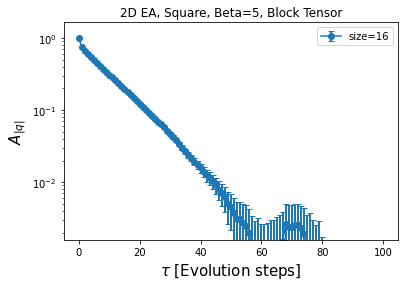

In [109]:
plt.errorbar(x=range(101), y=autocorr_q_ea2d_16_mean, yerr=autocorr_q_ea2d_16_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
plt.yscale("log")
plt.ylim(10**-2.8)
plt.xlabel(r'$\tau$ [Evolution steps]', fontsize=15)
plt.ylabel(r'$A_{|q|}$', fontsize=15)
plt.title("2D EA, Square, Beta=5, Block Tensor")
plt.legend()

In [95]:
q_abs_mean_16 = np.mean(np.abs(q_ea2d_16))

In [96]:
autocorr_time_size_16 = np.sum(autocorr_q_ea2d_16_mean) - 1/2

In [97]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 8.510.


In [98]:
autocorr_time_size_16 = autocorr_time_est(autocorr_q_ea2d_16_mean[:10], 1000)

In [99]:
print(f"autocorr time of size 16 is: {autocorr_time_size_16:.3f}.")

autocorr time of size 16 is: 9.286.


-----------
### Size = 32

In [118]:
with open('./data_2d_ea/ea_square_size_32_tensor/ea_square_size_32_beta_5.000_h_0.000_5E4_frust_tensor_torch_v0.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_32_v0 = data_dict['q_list']

In [120]:
with open('./data_2d_ea/ea_square_size_32_tensor/ea_square_size_32_beta_5.000_h_0.000_5E4_frust_tensor_torch_v1.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_32_v1 = data_dict['q_list']

In [122]:
with open('./data_2d_ea/ea_square_size_32_tensor/ea_square_size_32_beta_5.000_h_0.000_5E4_frust_tensor_torch_v2.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_32_v2 = data_dict['q_list']

In [128]:
with open('./data_2d_ea/ea_square_size_32_tensor/ea_square_size_32_beta_5.000_h_0.000_5E4_frust_tensor_torch_v3.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_32_v3 = data_dict['q_list']

In [130]:
with open('./data_2d_ea/ea_square_size_32_tensor/ea_square_size_32_beta_5.000_h_0.000_5E4_frust_tensor_torch_v4.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_32_v4 = data_dict['q_list']

In [132]:
with open('./data_2d_ea/ea_square_size_32_tensor/ea_square_size_32_beta_5.000_h_0.000_5E4_frust_tensor_torch_v5.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_32_v5 = data_dict['q_list']

In [134]:
with open('./data_2d_ea/ea_square_size_32_tensor/ea_square_size_32_beta_5.000_h_0.000_5E4_frust_tensor_torch_v6.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    q_ea2d_32_v6 = data_dict['q_list']

<AxesSubplot:ylabel='Count'>

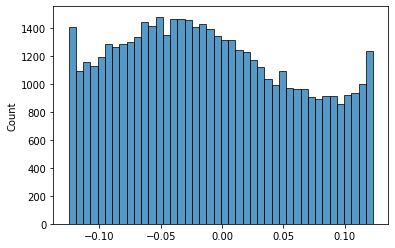

In [135]:
sns.histplot(q_ea2d_32_v6)

In [203]:
m_abs_2dising_32_j_pos = np.abs(m_2dising_32_j_pos)

In [204]:
m_abs_2dising_32_j_pos_mean = np.mean(m_abs_2dising_32_j_pos)

In [205]:
print(f"|m| of size 32 is: {m_abs_2dising_32_j_pos_mean:.3f}.")

|m| of size 32 is: 0.654.


In [206]:
m_abs_2dising_32_j_pos = m_abs_2dising_32_j_pos.reshape((10000, 2500))

In [207]:
time_start = time.time()
autocorr_m_abs_2dising_32_j_pos_mean, _, _, _ = autocorr_mc_mean_est(m_abs_2dising_32_j_pos, 250)
_, autocorr_m_abs_2dising_32_j_pos_std = autocorr_mc_std_est(m_abs_2dising_32_j_pos, 250)
time_end = time.time()
print(time_end-time_start)

33.3617057800293


In [208]:
autocorr_m_abs_2dising_32_j_pos_mean = np.insert(autocorr_m_abs_2dising_32_j_pos_mean, 0, 1)

In [209]:
autocorr_m_abs_2dising_32_j_pos_std = np.insert(autocorr_m_abs_2dising_32_j_pos_std, 0, 0)

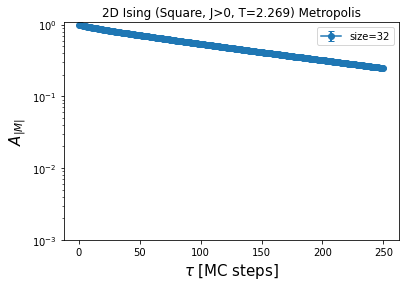

In [210]:
plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-3)
plt.xlabel(r'$\tau$ [MC steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("2D Ising (Square, J>0, T=2.269) Metropolis")
plt.legend()

In [211]:
autocorr_time_size_32 = np.sum(autocorr_m_abs_2dising_32_j_pos_mean) - 1/2

In [212]:
print(f"autocorr time of size 32 is: {autocorr_time_size_32:.3f}.")

autocorr time of size 32 is: 128.648.


In [252]:
autocorr_time_size_32 = autocorr_time_est(autocorr_m_abs_2dising_32_j_pos_mean, 1000000)

In [253]:
autocorr_time_size_32

184.98876527261083

In [224]:
42.550/100/ 3600 * 10000 * 15

17.729166666666668

In [225]:
135.369 / 100 / 3600 * 10000

3.76025

--------------
#### Summary

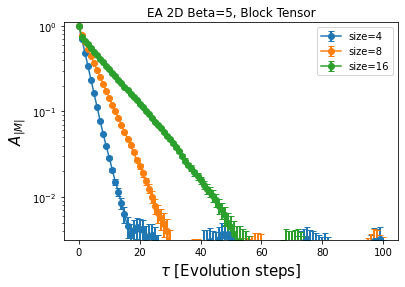

In [112]:
plt.errorbar(x=range(101), y=autocorr_q_ea2d_4_mean, yerr=autocorr_q_ea2d_4_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=4')
plt.errorbar(x=range(101), y=autocorr_q_ea2d_8_mean, yerr=autocorr_q_ea2d_8_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=8')
plt.errorbar(x=range(101), y=autocorr_q_ea2d_16_mean, yerr=autocorr_q_ea2d_8_std, 
             fmt='-o', capsize=3, elinewidth=2, label='size=16')
#plt.errorbar(x=range(251), y=autocorr_m_abs_2dising_32_j_pos_mean, yerr=autocorr_m_abs_2dising_32_j_pos_std, 
 #            fmt='-o', capsize=3, elinewidth=2, label='size=32')
plt.yscale("log")
plt.ylim(10**-2.5, 1.1)
plt.xlabel(r'$\tau$ [Evolution steps]', fontsize=15)
plt.ylabel(r'$A_{|M|}$', fontsize=15)
plt.title("EA 2D Beta=5, Block Tensor")
plt.legend()

### Size effect and Dynamical Exponent

In [101]:
#size_array = np.array([4, 8, 16, 32])
size_array = np.array([4, 8, 16])

In [102]:
autocorr_fun_array = np.array([q_abs_mean_4, 
                               q_abs_mean_8,
                               q_abs_mean_16,])

Text(0.5, 1.0, 'Size Effect on 2D Square EA')

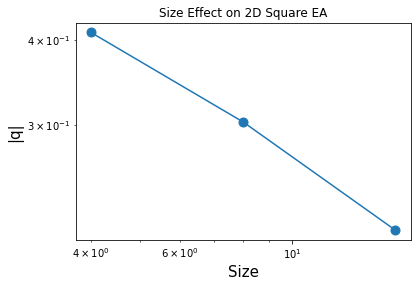

In [103]:
plt.plot(size_array, autocorr_fun_array, '-o', markersize=9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Size", fontsize=15)
plt.ylabel("|q|", fontsize=15)
plt.title("Size Effect on 2D Square EA")

In [104]:
autocorr_time_array = np.array([autocorr_time_size_4, 
                                autocorr_time_size_8,
                                autocorr_time_size_16,])# autocorr_time_size_32])

In [105]:
index_metropolis, bias = np.polyfit(np.log(size_array), np.log(autocorr_time_array), 1)

In [106]:
print(f"index of Block Tensor is about: {index_metropolis:.3f}.")

index of Block Tensor is about: 0.875.


In [107]:
print(f"Constant is: {np.exp(-bias):.3f}.")

Constant is: 1.228.


Text(0.5, 1.0, 'Block Tensor, EA, Square, Beta=5, Z=0.875')

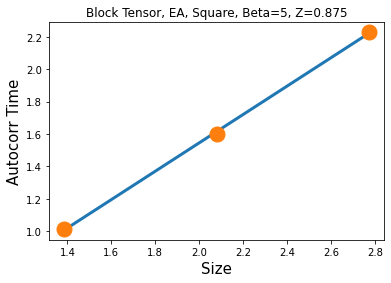

In [108]:
plt.plot(np.log(size_array), index_metropolis*np.log(size_array) + bias, linewidth=3)
plt.plot(np.log(size_array), np.log(autocorr_time_array), 'o', markersize=15)
plt.xlabel("Size", fontsize=15)
plt.ylabel("Autocorr Time", fontsize=15)
plt.title("Block Tensor, EA, Square, Beta=5, Z=0.875")

-----------------------------------------

In [114]:
np.exp(1.17)

3.2219926385284996